## 20-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기

In [45]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


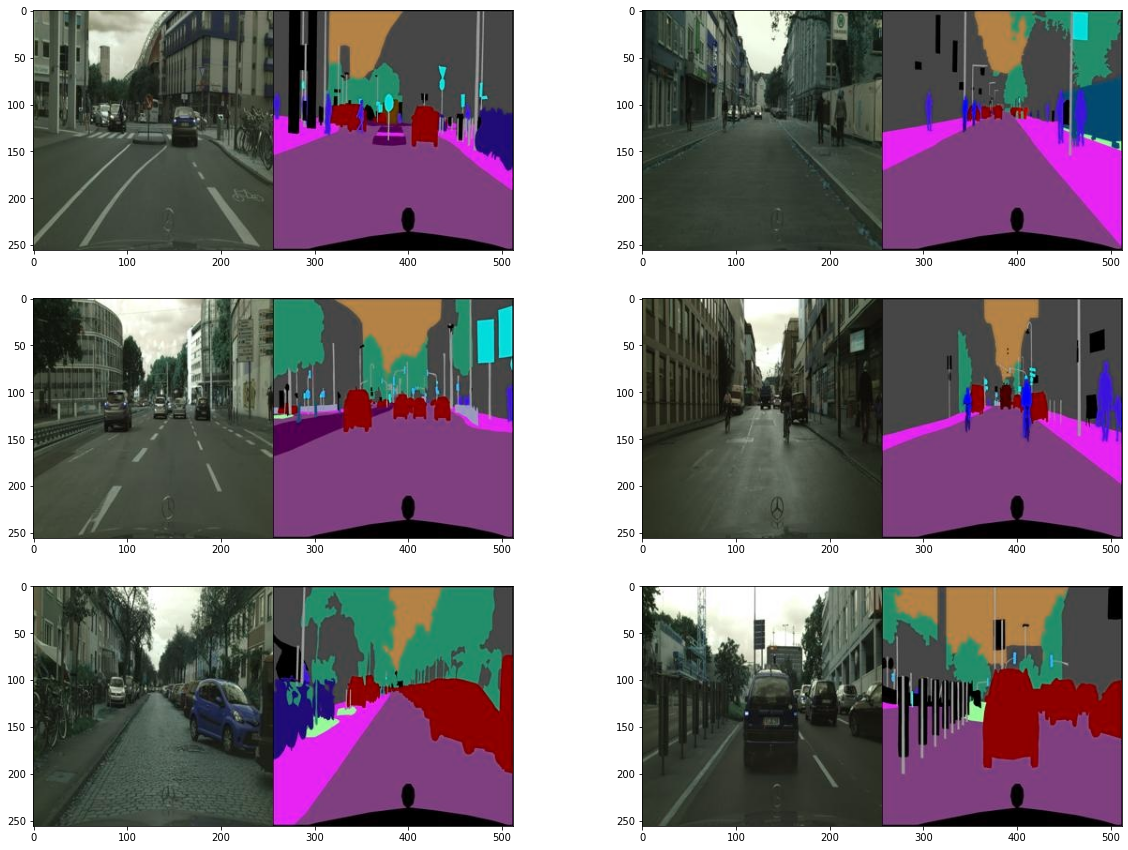

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [47]:
#이미지를 하나 열어 아래와 같이 크기를 확인해 보겠습니다
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


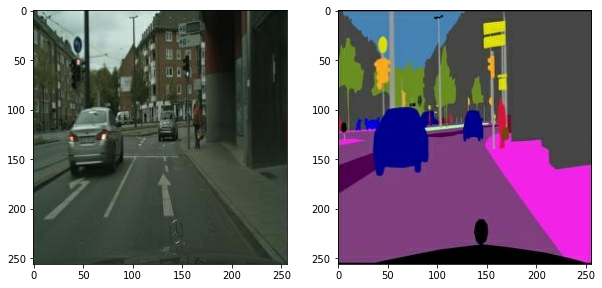

In [48]:
#모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 될 것 같네요.

import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))


In [49]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


### 1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요. (어떠한 방법을 사용했는지 적어주세요.)

*적용 augmentation
1. flip - left_right / up_down
2. crop
3. rotation - 90

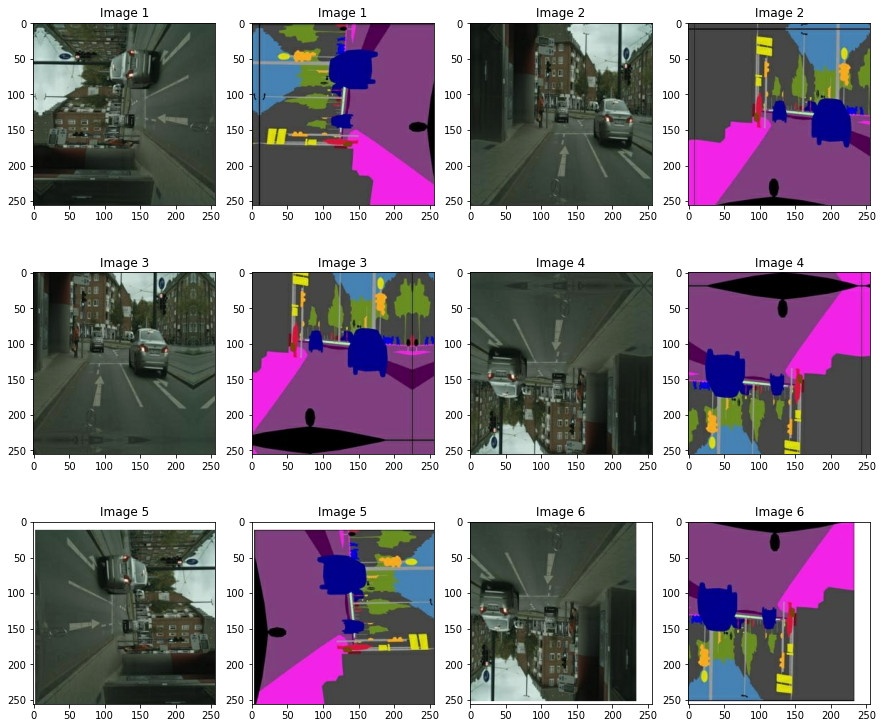

In [50]:
#구성한 함수를 데이터에 적용해 시각화 해봅시다.

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

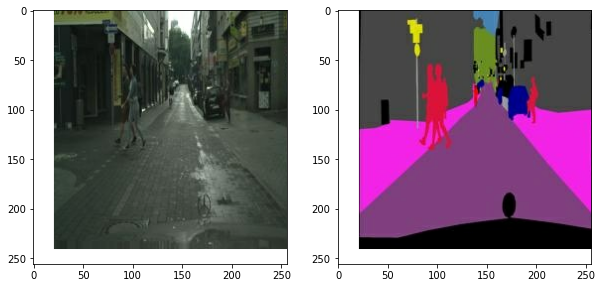

In [51]:
#위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보겠습니다.

from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### 2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.

In [52]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [53]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [54]:
UNetGenerator().get_summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_40 (EncodeBlock)   (None, 128, 128, 64) 3072        input_9[0][0]                    
__________________________________________________________________________________________________
encode_block_41 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_40[0][0]            
__________________________________________________________________________________________________
encode_block_42 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_41[0][0]            
____________________________________________________________________________________________

In [55]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [56]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_113 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [57]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [58]:
Discriminator().get_summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_42 (Concatenate)    (None, 256, 256, 6)  0           input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
disc_block_35 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_42[0][0]       

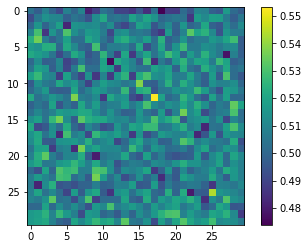

In [59]:
#시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해보겠습니다.

x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### 손실함수

In [60]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


Generator 및 Discriminator의 손실 계산을 각각 정의했습니다.

### optimizer


In [61]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [62]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [63]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0311                     
L1_loss:0.3443                     
Discriminator_loss:1.4973

EPOCH[1] - STEP[20]                     
Generator_loss:1.1795                     
L1_loss:0.3277                     
Discriminator_loss:1.0067

EPOCH[1] - STEP[30]                     
Generator_loss:1.3750                     
L1_loss:0.2419                     
Discriminator_loss:0.8731

EPOCH[1] - STEP[40]                     
Generator_loss:1.3723                     
L1_loss:0.2430                     
Discriminator_loss:1.0618

EPOCH[1] - STEP[50]                     
Generator_loss:1.4830                     
L1_loss:0.2274                     
Discriminator_loss:0.7615

EPOCH[1] - STEP[60]                     
Generator_loss:1.7725                     
L1_loss:0.2659                     
Discriminator_loss:0.8025

EPOCH[1] - STEP[70]                     
Generator_loss:1.2082                     
L1_loss:0.2681                    

EPOCH[3] - STEP[70]                     
Generator_loss:3.1589                     
L1_loss:0.2627                     
Discriminator_loss:0.2262

EPOCH[3] - STEP[80]                     
Generator_loss:2.5373                     
L1_loss:0.2107                     
Discriminator_loss:0.8298

EPOCH[3] - STEP[90]                     
Generator_loss:1.7235                     
L1_loss:0.2170                     
Discriminator_loss:0.5083

EPOCH[3] - STEP[100]                     
Generator_loss:1.4757                     
L1_loss:0.2426                     
Discriminator_loss:1.2802

EPOCH[3] - STEP[110]                     
Generator_loss:2.3894                     
L1_loss:0.1640                     
Discriminator_loss:0.5177

EPOCH[3] - STEP[120]                     
Generator_loss:1.0249                     
L1_loss:0.1997                     
Discriminator_loss:0.5676

EPOCH[3] - STEP[130]                     
Generator_loss:1.0772                     
L1_loss:0.1862                

EPOCH[5] - STEP[130]                     
Generator_loss:2.8125                     
L1_loss:0.1985                     
Discriminator_loss:0.4152

EPOCH[5] - STEP[140]                     
Generator_loss:2.4423                     
L1_loss:0.2273                     
Discriminator_loss:0.2340

EPOCH[5] - STEP[150]                     
Generator_loss:1.5357                     
L1_loss:0.1637                     
Discriminator_loss:0.7013

EPOCH[5] - STEP[160]                     
Generator_loss:1.2339                     
L1_loss:0.2007                     
Discriminator_loss:1.1039

EPOCH[5] - STEP[170]                     
Generator_loss:1.0074                     
L1_loss:0.2343                     
Discriminator_loss:0.8261

EPOCH[5] - STEP[180]                     
Generator_loss:1.8666                     
L1_loss:0.2369                     
Discriminator_loss:0.3053

EPOCH[5] - STEP[190]                     
Generator_loss:0.9961                     
L1_loss:0.1803             

EPOCH[7] - STEP[190]                     
Generator_loss:3.0034                     
L1_loss:0.1913                     
Discriminator_loss:1.7835

EPOCH[7] - STEP[200]                     
Generator_loss:2.0802                     
L1_loss:0.1925                     
Discriminator_loss:0.7073

EPOCH[7] - STEP[210]                     
Generator_loss:1.1474                     
L1_loss:0.1675                     
Discriminator_loss:0.8040

EPOCH[7] - STEP[220]                     
Generator_loss:1.6575                     
L1_loss:0.1988                     
Discriminator_loss:0.5992

EPOCH[7] - STEP[230]                     
Generator_loss:2.0780                     
L1_loss:0.2057                     
Discriminator_loss:0.7706

EPOCH[7] - STEP[240]                     
Generator_loss:1.5420                     
L1_loss:0.1723                     
Discriminator_loss:0.4625

EPOCH[7] - STEP[250]                     
Generator_loss:1.3844                     
L1_loss:0.1925             

EPOCH[9] - STEP[250]                     
Generator_loss:1.2046                     
L1_loss:0.2029                     
Discriminator_loss:0.4973

EPOCH[10] - STEP[10]                     
Generator_loss:1.1254                     
L1_loss:0.1527                     
Discriminator_loss:1.0471

EPOCH[10] - STEP[20]                     
Generator_loss:1.8656                     
L1_loss:0.2647                     
Discriminator_loss:0.4716

EPOCH[10] - STEP[30]                     
Generator_loss:0.9861                     
L1_loss:0.2191                     
Discriminator_loss:0.6543

EPOCH[10] - STEP[40]                     
Generator_loss:1.0338                     
L1_loss:0.1726                     
Discriminator_loss:0.6498

EPOCH[10] - STEP[50]                     
Generator_loss:0.9509                     
L1_loss:0.1830                     
Discriminator_loss:0.8138

EPOCH[10] - STEP[60]                     
Generator_loss:2.4608                     
L1_loss:0.1442             

EPOCH[12] - STEP[60]                     
Generator_loss:1.0615                     
L1_loss:0.2056                     
Discriminator_loss:0.6337

EPOCH[12] - STEP[70]                     
Generator_loss:2.6189                     
L1_loss:0.1561                     
Discriminator_loss:1.0755

EPOCH[12] - STEP[80]                     
Generator_loss:1.1597                     
L1_loss:0.1936                     
Discriminator_loss:0.5116

EPOCH[12] - STEP[90]                     
Generator_loss:1.7307                     
L1_loss:0.1822                     
Discriminator_loss:0.3364

EPOCH[12] - STEP[100]                     
Generator_loss:3.5297                     
L1_loss:0.1729                     
Discriminator_loss:1.3861

EPOCH[12] - STEP[110]                     
Generator_loss:2.8549                     
L1_loss:0.1677                     
Discriminator_loss:0.2582

EPOCH[12] - STEP[120]                     
Generator_loss:1.6024                     
L1_loss:0.1730          

EPOCH[14] - STEP[120]                     
Generator_loss:1.7690                     
L1_loss:0.2090                     
Discriminator_loss:0.5046

EPOCH[14] - STEP[130]                     
Generator_loss:0.8565                     
L1_loss:0.1844                     
Discriminator_loss:1.2013

EPOCH[14] - STEP[140]                     
Generator_loss:2.3583                     
L1_loss:0.1730                     
Discriminator_loss:0.3688

EPOCH[14] - STEP[150]                     
Generator_loss:2.2335                     
L1_loss:0.1473                     
Discriminator_loss:0.5645

EPOCH[14] - STEP[160]                     
Generator_loss:1.4775                     
L1_loss:0.2019                     
Discriminator_loss:0.3853

EPOCH[14] - STEP[170]                     
Generator_loss:0.8814                     
L1_loss:0.1635                     
Discriminator_loss:0.7993

EPOCH[14] - STEP[180]                     
Generator_loss:1.0467                     
L1_loss:0.2157      

EPOCH[16] - STEP[180]                     
Generator_loss:0.6236                     
L1_loss:0.1581                     
Discriminator_loss:1.2771

EPOCH[16] - STEP[190]                     
Generator_loss:0.8797                     
L1_loss:0.1429                     
Discriminator_loss:0.7790

EPOCH[16] - STEP[200]                     
Generator_loss:3.4015                     
L1_loss:0.1873                     
Discriminator_loss:0.2366

EPOCH[16] - STEP[210]                     
Generator_loss:2.2932                     
L1_loss:0.1694                     
Discriminator_loss:0.4982

EPOCH[16] - STEP[220]                     
Generator_loss:1.7323                     
L1_loss:0.1877                     
Discriminator_loss:0.3475

EPOCH[16] - STEP[230]                     
Generator_loss:1.5777                     
L1_loss:0.1694                     
Discriminator_loss:0.9380

EPOCH[16] - STEP[240]                     
Generator_loss:2.2479                     
L1_loss:0.1841      

EPOCH[18] - STEP[240]                     
Generator_loss:1.7540                     
L1_loss:0.2168                     
Discriminator_loss:0.3257

EPOCH[18] - STEP[250]                     
Generator_loss:2.9618                     
L1_loss:0.1565                     
Discriminator_loss:0.5539

EPOCH[19] - STEP[10]                     
Generator_loss:0.6737                     
L1_loss:0.1703                     
Discriminator_loss:1.2876

EPOCH[19] - STEP[20]                     
Generator_loss:1.8531                     
L1_loss:0.1704                     
Discriminator_loss:0.6907

EPOCH[19] - STEP[30]                     
Generator_loss:2.6323                     
L1_loss:0.1331                     
Discriminator_loss:1.2052

EPOCH[19] - STEP[40]                     
Generator_loss:2.7157                     
L1_loss:0.1370                     
Discriminator_loss:0.6789

EPOCH[19] - STEP[50]                     
Generator_loss:1.5684                     
L1_loss:0.2070           

EPOCH[21] - STEP[50]                     
Generator_loss:1.3360                     
L1_loss:0.1820                     
Discriminator_loss:0.6845

EPOCH[21] - STEP[60]                     
Generator_loss:2.9974                     
L1_loss:0.1795                     
Discriminator_loss:0.3206

EPOCH[21] - STEP[70]                     
Generator_loss:1.4846                     
L1_loss:0.1554                     
Discriminator_loss:0.4517

EPOCH[21] - STEP[80]                     
Generator_loss:1.5256                     
L1_loss:0.1636                     
Discriminator_loss:0.4281

EPOCH[21] - STEP[90]                     
Generator_loss:3.3380                     
L1_loss:0.1285                     
Discriminator_loss:0.3917

EPOCH[21] - STEP[100]                     
Generator_loss:1.6535                     
L1_loss:0.1422                     
Discriminator_loss:1.5110

EPOCH[21] - STEP[110]                     
Generator_loss:1.3543                     
L1_loss:0.1488           

EPOCH[23] - STEP[110]                     
Generator_loss:2.2127                     
L1_loss:0.1503                     
Discriminator_loss:0.4719

EPOCH[23] - STEP[120]                     
Generator_loss:3.1399                     
L1_loss:0.1691                     
Discriminator_loss:0.1290

EPOCH[23] - STEP[130]                     
Generator_loss:2.0158                     
L1_loss:0.2043                     
Discriminator_loss:0.2580

EPOCH[23] - STEP[140]                     
Generator_loss:1.3048                     
L1_loss:0.1487                     
Discriminator_loss:0.5148

EPOCH[23] - STEP[150]                     
Generator_loss:1.1597                     
L1_loss:0.1731                     
Discriminator_loss:0.8125

EPOCH[23] - STEP[160]                     
Generator_loss:1.7788                     
L1_loss:0.1765                     
Discriminator_loss:0.3222

EPOCH[23] - STEP[170]                     
Generator_loss:2.1671                     
L1_loss:0.1416      

EPOCH[25] - STEP[170]                     
Generator_loss:2.4739                     
L1_loss:0.1664                     
Discriminator_loss:0.3768

EPOCH[25] - STEP[180]                     
Generator_loss:1.4805                     
L1_loss:0.1694                     
Discriminator_loss:0.8892

EPOCH[25] - STEP[190]                     
Generator_loss:1.9094                     
L1_loss:0.1638                     
Discriminator_loss:0.5971

EPOCH[25] - STEP[200]                     
Generator_loss:1.9159                     
L1_loss:0.1473                     
Discriminator_loss:0.4282

EPOCH[25] - STEP[210]                     
Generator_loss:4.6122                     
L1_loss:0.1926                     
Discriminator_loss:0.6208

EPOCH[25] - STEP[220]                     
Generator_loss:1.8012                     
L1_loss:0.1702                     
Discriminator_loss:0.3155

EPOCH[25] - STEP[230]                     
Generator_loss:2.8823                     
L1_loss:0.2160      

EPOCH[27] - STEP[230]                     
Generator_loss:2.2523                     
L1_loss:0.1825                     
Discriminator_loss:0.2889

EPOCH[27] - STEP[240]                     
Generator_loss:1.3025                     
L1_loss:0.1271                     
Discriminator_loss:0.6258

EPOCH[27] - STEP[250]                     
Generator_loss:2.1750                     
L1_loss:0.1705                     
Discriminator_loss:0.5496

EPOCH[28] - STEP[10]                     
Generator_loss:2.4904                     
L1_loss:0.1438                     
Discriminator_loss:0.5393

EPOCH[28] - STEP[20]                     
Generator_loss:1.0554                     
L1_loss:0.1524                     
Discriminator_loss:0.9909

EPOCH[28] - STEP[30]                     
Generator_loss:2.4682                     
L1_loss:0.1668                     
Discriminator_loss:0.2009

EPOCH[28] - STEP[40]                     
Generator_loss:1.9964                     
L1_loss:0.1891          

EPOCH[30] - STEP[40]                     
Generator_loss:0.8537                     
L1_loss:0.1638                     
Discriminator_loss:0.7549

EPOCH[30] - STEP[50]                     
Generator_loss:3.3613                     
L1_loss:0.1455                     
Discriminator_loss:0.3111

EPOCH[30] - STEP[60]                     
Generator_loss:3.5350                     
L1_loss:0.1538                     
Discriminator_loss:0.2281

EPOCH[30] - STEP[70]                     
Generator_loss:2.2493                     
L1_loss:0.1305                     
Discriminator_loss:0.9701

EPOCH[30] - STEP[80]                     
Generator_loss:2.7750                     
L1_loss:0.1565                     
Discriminator_loss:0.6709

EPOCH[30] - STEP[90]                     
Generator_loss:0.3402                     
L1_loss:0.1716                     
Discriminator_loss:2.2762

EPOCH[30] - STEP[100]                     
Generator_loss:3.5039                     
L1_loss:0.1225            

EPOCH[32] - STEP[100]                     
Generator_loss:2.2389                     
L1_loss:0.1659                     
Discriminator_loss:0.2616

EPOCH[32] - STEP[110]                     
Generator_loss:3.1440                     
L1_loss:0.1547                     
Discriminator_loss:1.4022

EPOCH[32] - STEP[120]                     
Generator_loss:0.3210                     
L1_loss:0.1572                     
Discriminator_loss:1.6538

EPOCH[32] - STEP[130]                     
Generator_loss:0.6285                     
L1_loss:0.1399                     
Discriminator_loss:1.3084

EPOCH[32] - STEP[140]                     
Generator_loss:3.1969                     
L1_loss:0.1404                     
Discriminator_loss:0.1958

EPOCH[32] - STEP[150]                     
Generator_loss:0.9660                     
L1_loss:0.1415                     
Discriminator_loss:0.8722

EPOCH[32] - STEP[160]                     
Generator_loss:1.8735                     
L1_loss:0.1848      

EPOCH[34] - STEP[160]                     
Generator_loss:1.2433                     
L1_loss:0.1590                     
Discriminator_loss:0.7066

EPOCH[34] - STEP[170]                     
Generator_loss:4.5158                     
L1_loss:0.1312                     
Discriminator_loss:1.8283

EPOCH[34] - STEP[180]                     
Generator_loss:2.8760                     
L1_loss:0.1577                     
Discriminator_loss:0.2540

EPOCH[34] - STEP[190]                     
Generator_loss:2.4460                     
L1_loss:0.1285                     
Discriminator_loss:0.2992

EPOCH[34] - STEP[200]                     
Generator_loss:1.3096                     
L1_loss:0.1293                     
Discriminator_loss:0.5952

EPOCH[34] - STEP[210]                     
Generator_loss:1.9368                     
L1_loss:0.1659                     
Discriminator_loss:0.3055

EPOCH[34] - STEP[220]                     
Generator_loss:3.6484                     
L1_loss:0.1552      

EPOCH[36] - STEP[220]                     
Generator_loss:2.1041                     
L1_loss:0.1415                     
Discriminator_loss:0.3095

EPOCH[36] - STEP[230]                     
Generator_loss:0.7177                     
L1_loss:0.1796                     
Discriminator_loss:1.1764

EPOCH[36] - STEP[240]                     
Generator_loss:1.7591                     
L1_loss:0.1520                     
Discriminator_loss:0.5608

EPOCH[36] - STEP[250]                     
Generator_loss:1.7217                     
L1_loss:0.1777                     
Discriminator_loss:0.2922

EPOCH[37] - STEP[10]                     
Generator_loss:2.4955                     
L1_loss:0.1326                     
Discriminator_loss:0.5860

EPOCH[37] - STEP[20]                     
Generator_loss:1.9592                     
L1_loss:0.1441                     
Discriminator_loss:0.3396

EPOCH[37] - STEP[30]                     
Generator_loss:1.3059                     
L1_loss:0.1452         

EPOCH[39] - STEP[30]                     
Generator_loss:1.4429                     
L1_loss:0.1305                     
Discriminator_loss:0.7548

EPOCH[39] - STEP[40]                     
Generator_loss:3.4972                     
L1_loss:0.1678                     
Discriminator_loss:0.1161

EPOCH[39] - STEP[50]                     
Generator_loss:0.4810                     
L1_loss:0.1195                     
Discriminator_loss:1.3717

EPOCH[39] - STEP[60]                     
Generator_loss:2.4484                     
L1_loss:0.1276                     
Discriminator_loss:0.4607

EPOCH[39] - STEP[70]                     
Generator_loss:1.6729                     
L1_loss:0.1696                     
Discriminator_loss:0.4699

EPOCH[39] - STEP[80]                     
Generator_loss:2.3531                     
L1_loss:0.1453                     
Discriminator_loss:0.8167

EPOCH[39] - STEP[90]                     
Generator_loss:2.4853                     
L1_loss:0.1329             

EPOCH[41] - STEP[90]                     
Generator_loss:2.4002                     
L1_loss:0.1257                     
Discriminator_loss:0.5497

EPOCH[41] - STEP[100]                     
Generator_loss:1.4679                     
L1_loss:0.1377                     
Discriminator_loss:0.4591

EPOCH[41] - STEP[110]                     
Generator_loss:1.1783                     
L1_loss:0.1430                     
Discriminator_loss:0.9286

EPOCH[41] - STEP[120]                     
Generator_loss:3.0588                     
L1_loss:0.1486                     
Discriminator_loss:0.2917

EPOCH[41] - STEP[130]                     
Generator_loss:1.3755                     
L1_loss:0.1352                     
Discriminator_loss:0.4676

EPOCH[41] - STEP[140]                     
Generator_loss:3.2637                     
L1_loss:0.1370                     
Discriminator_loss:0.2281

EPOCH[41] - STEP[150]                     
Generator_loss:1.5795                     
L1_loss:0.1519       

EPOCH[43] - STEP[150]                     
Generator_loss:2.3451                     
L1_loss:0.1337                     
Discriminator_loss:0.4672

EPOCH[43] - STEP[160]                     
Generator_loss:2.1196                     
L1_loss:0.1659                     
Discriminator_loss:0.3605

EPOCH[43] - STEP[170]                     
Generator_loss:4.0159                     
L1_loss:0.1343                     
Discriminator_loss:1.3369

EPOCH[43] - STEP[180]                     
Generator_loss:3.6071                     
L1_loss:0.1172                     
Discriminator_loss:2.4650

EPOCH[43] - STEP[190]                     
Generator_loss:2.0112                     
L1_loss:0.1224                     
Discriminator_loss:0.8683

EPOCH[43] - STEP[200]                     
Generator_loss:1.3961                     
L1_loss:0.1299                     
Discriminator_loss:0.6809

EPOCH[43] - STEP[210]                     
Generator_loss:2.6261                     
L1_loss:0.1639      

EPOCH[45] - STEP[210]                     
Generator_loss:3.9699                     
L1_loss:0.1761                     
Discriminator_loss:0.0823

EPOCH[45] - STEP[220]                     
Generator_loss:7.1166                     
L1_loss:0.1543                     
Discriminator_loss:2.3444

EPOCH[45] - STEP[230]                     
Generator_loss:3.3408                     
L1_loss:0.1735                     
Discriminator_loss:0.1829

EPOCH[45] - STEP[240]                     
Generator_loss:1.3047                     
L1_loss:0.1373                     
Discriminator_loss:0.7622

EPOCH[45] - STEP[250]                     
Generator_loss:3.9985                     
L1_loss:0.1165                     
Discriminator_loss:1.0109

EPOCH[46] - STEP[10]                     
Generator_loss:3.9017                     
L1_loss:0.1423                     
Discriminator_loss:0.5406

EPOCH[46] - STEP[20]                     
Generator_loss:1.6826                     
L1_loss:0.1624        

EPOCH[48] - STEP[20]                     
Generator_loss:1.2668                     
L1_loss:0.1543                     
Discriminator_loss:0.6840

EPOCH[48] - STEP[30]                     
Generator_loss:1.8882                     
L1_loss:0.1309                     
Discriminator_loss:0.4204

EPOCH[48] - STEP[40]                     
Generator_loss:1.4413                     
L1_loss:0.1933                     
Discriminator_loss:0.7154

EPOCH[48] - STEP[50]                     
Generator_loss:2.3711                     
L1_loss:0.1572                     
Discriminator_loss:0.2254

EPOCH[48] - STEP[60]                     
Generator_loss:1.1522                     
L1_loss:0.1334                     
Discriminator_loss:0.9075

EPOCH[48] - STEP[70]                     
Generator_loss:0.5346                     
L1_loss:0.1330                     
Discriminator_loss:1.2925

EPOCH[48] - STEP[80]                     
Generator_loss:1.6153                     
L1_loss:0.1402             

EPOCH[50] - STEP[80]                     
Generator_loss:4.2782                     
L1_loss:0.1676                     
Discriminator_loss:0.1013

EPOCH[50] - STEP[90]                     
Generator_loss:1.0458                     
L1_loss:0.1450                     
Discriminator_loss:0.9114

EPOCH[50] - STEP[100]                     
Generator_loss:2.1166                     
L1_loss:0.1403                     
Discriminator_loss:0.2759

EPOCH[50] - STEP[110]                     
Generator_loss:2.8631                     
L1_loss:0.1253                     
Discriminator_loss:0.3852

EPOCH[50] - STEP[120]                     
Generator_loss:2.2237                     
L1_loss:0.1840                     
Discriminator_loss:0.2628

EPOCH[50] - STEP[130]                     
Generator_loss:0.5468                     
L1_loss:0.1066                     
Discriminator_loss:1.5700

EPOCH[50] - STEP[140]                     
Generator_loss:5.4101                     
L1_loss:0.1368        

EPOCH[52] - STEP[140]                     
Generator_loss:3.7167                     
L1_loss:0.1180                     
Discriminator_loss:0.9018

EPOCH[52] - STEP[150]                     
Generator_loss:1.2995                     
L1_loss:0.1417                     
Discriminator_loss:0.6297

EPOCH[52] - STEP[160]                     
Generator_loss:2.6037                     
L1_loss:0.1385                     
Discriminator_loss:0.2791

EPOCH[52] - STEP[170]                     
Generator_loss:4.4707                     
L1_loss:0.1560                     
Discriminator_loss:0.4405

EPOCH[52] - STEP[180]                     
Generator_loss:1.9905                     
L1_loss:0.1602                     
Discriminator_loss:0.2417

EPOCH[52] - STEP[190]                     
Generator_loss:1.8986                     
L1_loss:0.1276                     
Discriminator_loss:0.5155

EPOCH[52] - STEP[200]                     
Generator_loss:0.8897                     
L1_loss:0.1370      

EPOCH[54] - STEP[200]                     
Generator_loss:1.9524                     
L1_loss:0.1908                     
Discriminator_loss:0.3361

EPOCH[54] - STEP[210]                     
Generator_loss:2.7252                     
L1_loss:0.1367                     
Discriminator_loss:0.3354

EPOCH[54] - STEP[220]                     
Generator_loss:1.0109                     
L1_loss:0.1176                     
Discriminator_loss:0.8944

EPOCH[54] - STEP[230]                     
Generator_loss:4.4064                     
L1_loss:0.1256                     
Discriminator_loss:1.0949

EPOCH[54] - STEP[240]                     
Generator_loss:0.4447                     
L1_loss:0.1479                     
Discriminator_loss:1.8952

EPOCH[54] - STEP[250]                     
Generator_loss:2.9885                     
L1_loss:0.1491                     
Discriminator_loss:0.3174

EPOCH[55] - STEP[10]                     
Generator_loss:0.6009                     
L1_loss:0.1877       

EPOCH[57] - STEP[10]                     
Generator_loss:1.4379                     
L1_loss:0.1343                     
Discriminator_loss:0.5306

EPOCH[57] - STEP[20]                     
Generator_loss:3.6218                     
L1_loss:0.1324                     
Discriminator_loss:0.2517

EPOCH[57] - STEP[30]                     
Generator_loss:2.4630                     
L1_loss:0.1489                     
Discriminator_loss:0.3812

EPOCH[57] - STEP[40]                     
Generator_loss:3.3032                     
L1_loss:0.1379                     
Discriminator_loss:0.5044

EPOCH[57] - STEP[50]                     
Generator_loss:4.2968                     
L1_loss:0.1189                     
Discriminator_loss:1.3505

EPOCH[57] - STEP[60]                     
Generator_loss:1.7267                     
L1_loss:0.1221                     
Discriminator_loss:0.4163

EPOCH[57] - STEP[70]                     
Generator_loss:4.4153                     
L1_loss:0.1165             

EPOCH[59] - STEP[70]                     
Generator_loss:2.3733                     
L1_loss:0.1427                     
Discriminator_loss:0.2936

EPOCH[59] - STEP[80]                     
Generator_loss:1.9715                     
L1_loss:0.1284                     
Discriminator_loss:0.3196

EPOCH[59] - STEP[90]                     
Generator_loss:2.1324                     
L1_loss:0.1120                     
Discriminator_loss:0.5368

EPOCH[59] - STEP[100]                     
Generator_loss:1.8841                     
L1_loss:0.1450                     
Discriminator_loss:0.2450

EPOCH[59] - STEP[110]                     
Generator_loss:2.5138                     
L1_loss:0.1421                     
Discriminator_loss:0.1420

EPOCH[59] - STEP[120]                     
Generator_loss:1.3435                     
L1_loss:0.1388                     
Discriminator_loss:0.4986

EPOCH[59] - STEP[130]                     
Generator_loss:2.1885                     
L1_loss:0.1618         

EPOCH[61] - STEP[130]                     
Generator_loss:3.4366                     
L1_loss:0.1202                     
Discriminator_loss:0.3579

EPOCH[61] - STEP[140]                     
Generator_loss:2.0407                     
L1_loss:0.1211                     
Discriminator_loss:0.7287

EPOCH[61] - STEP[150]                     
Generator_loss:2.3264                     
L1_loss:0.1540                     
Discriminator_loss:0.4485

EPOCH[61] - STEP[160]                     
Generator_loss:3.3683                     
L1_loss:0.1289                     
Discriminator_loss:0.2034

EPOCH[61] - STEP[170]                     
Generator_loss:3.0980                     
L1_loss:0.1598                     
Discriminator_loss:0.1592

EPOCH[61] - STEP[180]                     
Generator_loss:3.5010                     
L1_loss:0.1450                     
Discriminator_loss:0.0842

EPOCH[61] - STEP[190]                     
Generator_loss:2.9741                     
L1_loss:0.1902      

EPOCH[63] - STEP[190]                     
Generator_loss:3.8895                     
L1_loss:0.1364                     
Discriminator_loss:0.5409

EPOCH[63] - STEP[200]                     
Generator_loss:5.3506                     
L1_loss:0.1886                     
Discriminator_loss:0.1034

EPOCH[63] - STEP[210]                     
Generator_loss:3.1889                     
L1_loss:0.1279                     
Discriminator_loss:0.3610

EPOCH[63] - STEP[220]                     
Generator_loss:6.4740                     
L1_loss:0.1336                     
Discriminator_loss:2.2469

EPOCH[63] - STEP[230]                     
Generator_loss:2.6482                     
L1_loss:0.1317                     
Discriminator_loss:0.2181

EPOCH[63] - STEP[240]                     
Generator_loss:5.2963                     
L1_loss:0.1445                     
Discriminator_loss:0.1512

EPOCH[63] - STEP[250]                     
Generator_loss:1.7045                     
L1_loss:0.1163      

EPOCH[65] - STEP[250]                     
Generator_loss:2.6183                     
L1_loss:0.1144                     
Discriminator_loss:0.1938

EPOCH[66] - STEP[10]                     
Generator_loss:2.2386                     
L1_loss:0.1357                     
Discriminator_loss:0.5779

EPOCH[66] - STEP[20]                     
Generator_loss:3.1240                     
L1_loss:0.1493                     
Discriminator_loss:0.2675

EPOCH[66] - STEP[30]                     
Generator_loss:0.8666                     
L1_loss:0.1423                     
Discriminator_loss:0.8619

EPOCH[66] - STEP[40]                     
Generator_loss:1.1648                     
L1_loss:0.1248                     
Discriminator_loss:0.6726

EPOCH[66] - STEP[50]                     
Generator_loss:2.3330                     
L1_loss:0.1702                     
Discriminator_loss:0.2168

EPOCH[66] - STEP[60]                     
Generator_loss:3.2109                     
L1_loss:0.1007            

EPOCH[68] - STEP[60]                     
Generator_loss:1.3530                     
L1_loss:0.1105                     
Discriminator_loss:1.9025

EPOCH[68] - STEP[70]                     
Generator_loss:4.2382                     
L1_loss:0.1377                     
Discriminator_loss:0.1165

EPOCH[68] - STEP[80]                     
Generator_loss:3.9035                     
L1_loss:0.1680                     
Discriminator_loss:0.0860

EPOCH[68] - STEP[90]                     
Generator_loss:5.2631                     
L1_loss:0.1732                     
Discriminator_loss:0.3494

EPOCH[68] - STEP[100]                     
Generator_loss:0.9033                     
L1_loss:0.1169                     
Discriminator_loss:0.8470

EPOCH[68] - STEP[110]                     
Generator_loss:2.3855                     
L1_loss:0.1108                     
Discriminator_loss:0.9330

EPOCH[68] - STEP[120]                     
Generator_loss:3.4723                     
L1_loss:0.1614          

EPOCH[70] - STEP[120]                     
Generator_loss:3.8435                     
L1_loss:0.1968                     
Discriminator_loss:0.2369

EPOCH[70] - STEP[130]                     
Generator_loss:3.4419                     
L1_loss:0.1247                     
Discriminator_loss:0.1437

EPOCH[70] - STEP[140]                     
Generator_loss:3.3458                     
L1_loss:0.1344                     
Discriminator_loss:0.3963

EPOCH[70] - STEP[150]                     
Generator_loss:1.8044                     
L1_loss:0.1113                     
Discriminator_loss:0.4369

EPOCH[70] - STEP[160]                     
Generator_loss:3.6713                     
L1_loss:0.1496                     
Discriminator_loss:0.1523

EPOCH[70] - STEP[170]                     
Generator_loss:4.4634                     
L1_loss:0.1283                     
Discriminator_loss:0.0802

EPOCH[70] - STEP[180]                     
Generator_loss:1.8790                     
L1_loss:0.1351      

EPOCH[72] - STEP[180]                     
Generator_loss:4.3253                     
L1_loss:0.1333                     
Discriminator_loss:0.1801

EPOCH[72] - STEP[190]                     
Generator_loss:2.9613                     
L1_loss:0.1300                     
Discriminator_loss:0.1530

EPOCH[72] - STEP[200]                     
Generator_loss:5.5076                     
L1_loss:0.1295                     
Discriminator_loss:0.6270

EPOCH[72] - STEP[210]                     
Generator_loss:2.8304                     
L1_loss:0.1182                     
Discriminator_loss:0.3029

EPOCH[72] - STEP[220]                     
Generator_loss:4.7698                     
L1_loss:0.1491                     
Discriminator_loss:0.0689

EPOCH[72] - STEP[230]                     
Generator_loss:1.6627                     
L1_loss:0.1198                     
Discriminator_loss:0.3688

EPOCH[72] - STEP[240]                     
Generator_loss:5.8410                     
L1_loss:0.1262      

EPOCH[74] - STEP[240]                     
Generator_loss:2.2334                     
L1_loss:0.1515                     
Discriminator_loss:0.3051

EPOCH[74] - STEP[250]                     
Generator_loss:3.2765                     
L1_loss:0.1533                     
Discriminator_loss:0.1502

EPOCH[75] - STEP[10]                     
Generator_loss:1.7344                     
L1_loss:0.1696                     
Discriminator_loss:0.3917

EPOCH[75] - STEP[20]                     
Generator_loss:2.9619                     
L1_loss:0.1315                     
Discriminator_loss:0.9700

EPOCH[75] - STEP[30]                     
Generator_loss:4.1126                     
L1_loss:0.1155                     
Discriminator_loss:0.5075

EPOCH[75] - STEP[40]                     
Generator_loss:2.1974                     
L1_loss:0.1612                     
Discriminator_loss:0.2371

EPOCH[75] - STEP[50]                     
Generator_loss:0.9513                     
L1_loss:0.1854           

EPOCH[77] - STEP[50]                     
Generator_loss:1.5840                     
L1_loss:0.1344                     
Discriminator_loss:0.7506

EPOCH[77] - STEP[60]                     
Generator_loss:2.9783                     
L1_loss:0.1319                     
Discriminator_loss:0.2308

EPOCH[77] - STEP[70]                     
Generator_loss:0.9851                     
L1_loss:0.1033                     
Discriminator_loss:0.7892

EPOCH[77] - STEP[80]                     
Generator_loss:3.4165                     
L1_loss:0.1170                     
Discriminator_loss:0.1097

EPOCH[77] - STEP[90]                     
Generator_loss:4.9263                     
L1_loss:0.1188                     
Discriminator_loss:0.4109

EPOCH[77] - STEP[100]                     
Generator_loss:5.3847                     
L1_loss:0.1327                     
Discriminator_loss:0.4452

EPOCH[77] - STEP[110]                     
Generator_loss:2.9064                     
L1_loss:0.1204           

EPOCH[79] - STEP[110]                     
Generator_loss:2.9377                     
L1_loss:0.1966                     
Discriminator_loss:0.1546

EPOCH[79] - STEP[120]                     
Generator_loss:2.5862                     
L1_loss:0.1295                     
Discriminator_loss:0.2399

EPOCH[79] - STEP[130]                     
Generator_loss:5.2429                     
L1_loss:0.1210                     
Discriminator_loss:0.4434

EPOCH[79] - STEP[140]                     
Generator_loss:3.3303                     
L1_loss:0.1253                     
Discriminator_loss:0.2873

EPOCH[79] - STEP[150]                     
Generator_loss:4.5046                     
L1_loss:0.1126                     
Discriminator_loss:1.2402

EPOCH[79] - STEP[160]                     
Generator_loss:2.8145                     
L1_loss:0.1343                     
Discriminator_loss:0.1417

EPOCH[79] - STEP[170]                     
Generator_loss:2.0600                     
L1_loss:0.1704      

EPOCH[81] - STEP[170]                     
Generator_loss:2.8095                     
L1_loss:0.1413                     
Discriminator_loss:0.1432

EPOCH[81] - STEP[180]                     
Generator_loss:2.6054                     
L1_loss:0.1256                     
Discriminator_loss:0.3129

EPOCH[81] - STEP[190]                     
Generator_loss:2.6835                     
L1_loss:0.1416                     
Discriminator_loss:0.2372

EPOCH[81] - STEP[200]                     
Generator_loss:2.0189                     
L1_loss:0.1276                     
Discriminator_loss:0.2516

EPOCH[81] - STEP[210]                     
Generator_loss:1.5138                     
L1_loss:0.1337                     
Discriminator_loss:0.3881

EPOCH[81] - STEP[220]                     
Generator_loss:3.1560                     
L1_loss:0.1405                     
Discriminator_loss:0.1118

EPOCH[81] - STEP[230]                     
Generator_loss:2.2088                     
L1_loss:0.1804      

EPOCH[83] - STEP[230]                     
Generator_loss:1.8535                     
L1_loss:0.1438                     
Discriminator_loss:0.2938

EPOCH[83] - STEP[240]                     
Generator_loss:2.3159                     
L1_loss:0.1337                     
Discriminator_loss:0.6071

EPOCH[83] - STEP[250]                     
Generator_loss:1.5192                     
L1_loss:0.1167                     
Discriminator_loss:0.5809

EPOCH[84] - STEP[10]                     
Generator_loss:4.3241                     
L1_loss:0.1436                     
Discriminator_loss:0.8464

EPOCH[84] - STEP[20]                     
Generator_loss:3.6438                     
L1_loss:0.1150                     
Discriminator_loss:0.4290

EPOCH[84] - STEP[30]                     
Generator_loss:2.4166                     
L1_loss:0.1523                     
Discriminator_loss:0.1825

EPOCH[84] - STEP[40]                     
Generator_loss:2.4501                     
L1_loss:0.1554          

EPOCH[86] - STEP[40]                     
Generator_loss:4.2394                     
L1_loss:0.1270                     
Discriminator_loss:0.0995

EPOCH[86] - STEP[50]                     
Generator_loss:4.6514                     
L1_loss:0.1135                     
Discriminator_loss:0.3578

EPOCH[86] - STEP[60]                     
Generator_loss:2.5343                     
L1_loss:0.1397                     
Discriminator_loss:0.1934

EPOCH[86] - STEP[70]                     
Generator_loss:4.4021                     
L1_loss:0.1365                     
Discriminator_loss:0.1219

EPOCH[86] - STEP[80]                     
Generator_loss:3.7013                     
L1_loss:0.1455                     
Discriminator_loss:0.0961

EPOCH[86] - STEP[90]                     
Generator_loss:3.4920                     
L1_loss:0.1249                     
Discriminator_loss:0.1430

EPOCH[86] - STEP[100]                     
Generator_loss:2.6412                     
L1_loss:0.1160            

EPOCH[88] - STEP[100]                     
Generator_loss:1.1333                     
L1_loss:0.1559                     
Discriminator_loss:0.7729

EPOCH[88] - STEP[110]                     
Generator_loss:3.3023                     
L1_loss:0.1624                     
Discriminator_loss:0.1034

EPOCH[88] - STEP[120]                     
Generator_loss:3.4563                     
L1_loss:0.1127                     
Discriminator_loss:1.0774

EPOCH[88] - STEP[130]                     
Generator_loss:5.6077                     
L1_loss:0.1449                     
Discriminator_loss:0.4328

EPOCH[88] - STEP[140]                     
Generator_loss:5.9131                     
L1_loss:0.1395                     
Discriminator_loss:0.0708

EPOCH[88] - STEP[150]                     
Generator_loss:3.6216                     
L1_loss:0.1358                     
Discriminator_loss:0.1961

EPOCH[88] - STEP[160]                     
Generator_loss:2.3608                     
L1_loss:0.1520      

EPOCH[90] - STEP[160]                     
Generator_loss:2.2149                     
L1_loss:0.1401                     
Discriminator_loss:0.2194

EPOCH[90] - STEP[170]                     
Generator_loss:4.6411                     
L1_loss:0.1719                     
Discriminator_loss:0.0368

EPOCH[90] - STEP[180]                     
Generator_loss:4.0249                     
L1_loss:0.1143                     
Discriminator_loss:0.0723

EPOCH[90] - STEP[190]                     
Generator_loss:3.6384                     
L1_loss:0.1336                     
Discriminator_loss:0.5688

EPOCH[90] - STEP[200]                     
Generator_loss:1.2447                     
L1_loss:0.1388                     
Discriminator_loss:1.4210

EPOCH[90] - STEP[210]                     
Generator_loss:3.7491                     
L1_loss:0.1472                     
Discriminator_loss:0.2797

EPOCH[90] - STEP[220]                     
Generator_loss:4.2831                     
L1_loss:0.1678      

EPOCH[92] - STEP[220]                     
Generator_loss:6.3096                     
L1_loss:0.1235                     
Discriminator_loss:0.2700

EPOCH[92] - STEP[230]                     
Generator_loss:1.4398                     
L1_loss:0.1512                     
Discriminator_loss:0.4603

EPOCH[92] - STEP[240]                     
Generator_loss:1.3048                     
L1_loss:0.1322                     
Discriminator_loss:0.6151

EPOCH[92] - STEP[250]                     
Generator_loss:0.3062                     
L1_loss:0.1342                     
Discriminator_loss:1.8363

EPOCH[93] - STEP[10]                     
Generator_loss:2.8906                     
L1_loss:0.1897                     
Discriminator_loss:0.3125

EPOCH[93] - STEP[20]                     
Generator_loss:3.8334                     
L1_loss:0.1018                     
Discriminator_loss:1.5970

EPOCH[93] - STEP[30]                     
Generator_loss:2.8719                     
L1_loss:0.1376         

EPOCH[95] - STEP[30]                     
Generator_loss:2.9357                     
L1_loss:0.0936                     
Discriminator_loss:0.7239

EPOCH[95] - STEP[40]                     
Generator_loss:1.6993                     
L1_loss:0.1120                     
Discriminator_loss:0.3713

EPOCH[95] - STEP[50]                     
Generator_loss:1.2108                     
L1_loss:0.1557                     
Discriminator_loss:0.6508

EPOCH[95] - STEP[60]                     
Generator_loss:3.0734                     
L1_loss:0.1507                     
Discriminator_loss:0.1540

EPOCH[95] - STEP[70]                     
Generator_loss:4.0726                     
L1_loss:0.1292                     
Discriminator_loss:0.1522

EPOCH[95] - STEP[80]                     
Generator_loss:3.1176                     
L1_loss:0.1285                     
Discriminator_loss:0.1026

EPOCH[95] - STEP[90]                     
Generator_loss:5.0552                     
L1_loss:0.1156             

EPOCH[97] - STEP[90]                     
Generator_loss:1.3345                     
L1_loss:0.1109                     
Discriminator_loss:0.5776

EPOCH[97] - STEP[100]                     
Generator_loss:1.6762                     
L1_loss:0.1104                     
Discriminator_loss:0.5601

EPOCH[97] - STEP[110]                     
Generator_loss:1.3441                     
L1_loss:0.1175                     
Discriminator_loss:0.5608

EPOCH[97] - STEP[120]                     
Generator_loss:2.9566                     
L1_loss:0.1309                     
Discriminator_loss:0.5647

EPOCH[97] - STEP[130]                     
Generator_loss:3.3571                     
L1_loss:0.1146                     
Discriminator_loss:0.2220

EPOCH[97] - STEP[140]                     
Generator_loss:1.7937                     
L1_loss:0.0913                     
Discriminator_loss:0.3422

EPOCH[97] - STEP[150]                     
Generator_loss:2.8027                     
L1_loss:0.1157       

EPOCH[99] - STEP[150]                     
Generator_loss:3.4414                     
L1_loss:0.1276                     
Discriminator_loss:0.0727

EPOCH[99] - STEP[160]                     
Generator_loss:2.8320                     
L1_loss:0.1291                     
Discriminator_loss:0.1834

EPOCH[99] - STEP[170]                     
Generator_loss:3.8632                     
L1_loss:0.1424                     
Discriminator_loss:0.0518

EPOCH[99] - STEP[180]                     
Generator_loss:3.7756                     
L1_loss:0.1405                     
Discriminator_loss:0.1756

EPOCH[99] - STEP[190]                     
Generator_loss:6.1025                     
L1_loss:0.1520                     
Discriminator_loss:0.1571

EPOCH[99] - STEP[200]                     
Generator_loss:3.0319                     
L1_loss:0.1092                     
Discriminator_loss:0.4602

EPOCH[99] - STEP[210]                     
Generator_loss:2.1127                     
L1_loss:0.1218      

### 3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.

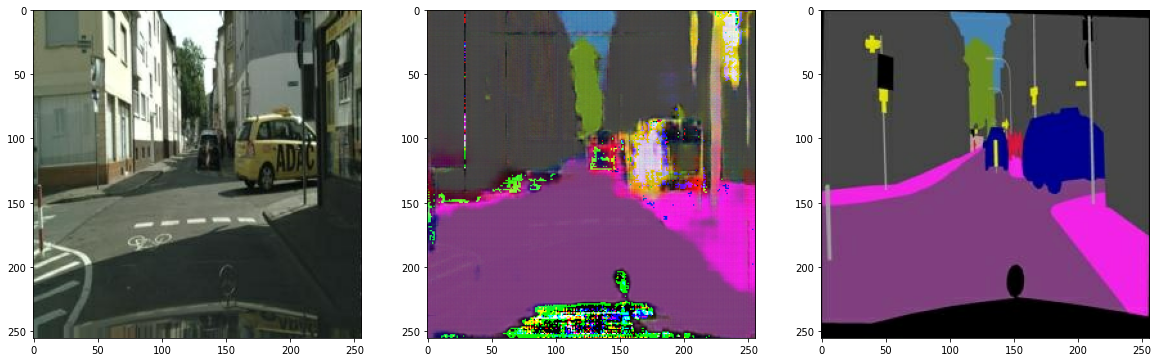

In [64]:
test_ind = 1
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

epoch == 10
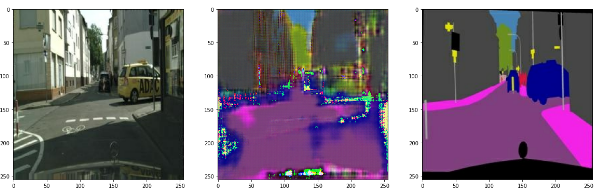

epoch == 20

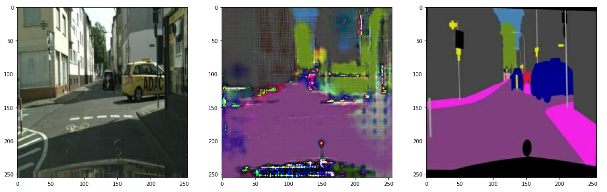

epoch ==100
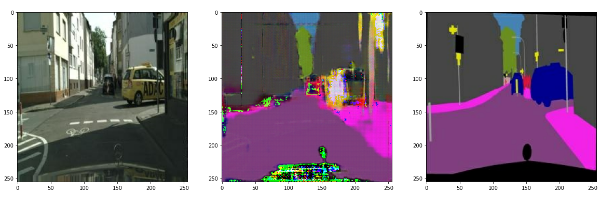

## 총평

* LMS를 통해서 GAN, DCGAN, CGAN을 배워 볼 수 있었다. 이번 CGAN의 경우, 단순한 원리를 추가한 구조인데, 조건을 주어 제어가 가능하고 다양한 활용이 가능해 졌다는 것과 논문이나 기타 자료를 통해 살펴보면서 이런한 차이를 보인다는 것에 놀라웠다. 기본을 정확히 아는것이 중요하구나 라는 생각을 했다. 새로운 모델을 창조하는것이 무에서 유가 아닌, 이런 단순한 시도에서 나온다는 것이 고무적이었다. 이 모델이 2014년에 나온것이라니, 이후의 다양한  GAN의 발전 된 모델을 배울 것이 기대된다. 

* 10번 이상의 학습을 하는것이 루브릭이었으며, 학습시간이 많이 소요되지 않아 100회까지 차이를 비교해 보았다. 성능은 나아졌으나, 100회 정도로는 학습량이 부족해 보인다.

* U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.